# Desarrollo por Joaquin Zepeda V.

Tarea 5 EL7008 - Clasificación de objetos usando CNNs.

El objetivo de esta tarea es implementar un sistema de clasificación de objetos usando redes neuronales
convolucionales (CNNs). En esta tarea se debe usar la librería pytorch para poder generar los tensores que
corresponden a las imágenes y sus labels (etiquetas), además de implementar arquitecturas de red y códigos
para entrenamiento y evaluación

In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-11-15 19:26:16--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.4’

cifar-10-python.tar 100%[===================>] 162.60M  21.7MB/s    in 9.2s    

2022-11-15 19:26:26 (17.7 MB/s) - ‘cifar-10-python.tar.gz.4’ saved [170498071/170498071]



In [2]:
!tar -xzvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
from torchvision import datasets, models, transforms
import time
import os
import random

SEED = 1234


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

device

'cuda'

# Sección 1. Implementar el código para que pytorch acceda a los datasets, para el conjunto de entrenamiento, validación y prueba.

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [6]:
L = unpickle("/content/cifar-10-batches-py/data_batch_1")

In [7]:
data,labels,filenames = L['data'],L['labels'],L['filenames']
metadata = unpickle("/content/cifar-10-batches-py/batches.meta")
label_names = metadata['label_names']

In [8]:
#he first 1024 entries contain the red channel values, the next 1024 the green, 
#and the final 1024 the blue. The image is stored in row-major order, so that the 
#first 32 entries of the array are the red channel values of the first row of the image.
data[0]

array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)

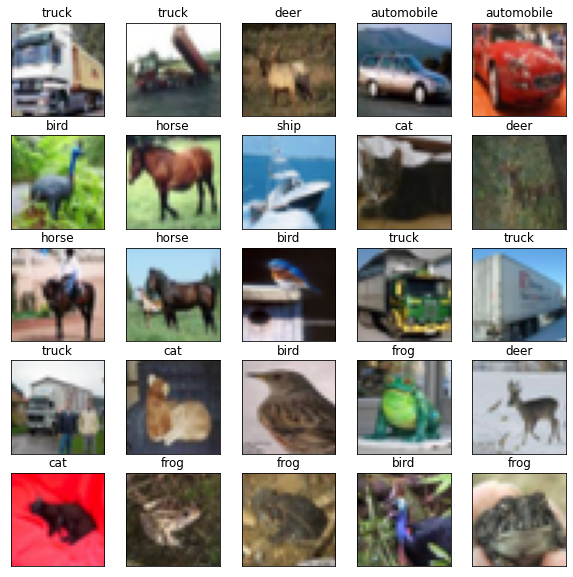

In [9]:
from google.colab.patches import cv2_imshow


fig=plt.figure(figsize=(10, 10))
for i in range(1, 26):
    fig.add_subplot(5, 5, i)
    img = np.reshape(data[i], (3,32,32)).transpose(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(label_names[labels[i]])
plt.show()

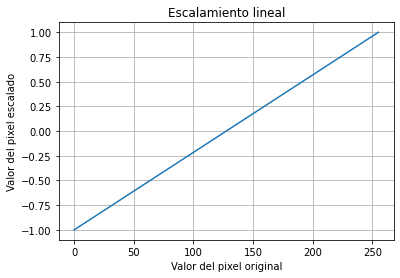

In [10]:
def escalamiento(x):
    return -1 + 2/255*x

x = np.arange(0,256,1)
plt.title("Escalamiento lineal")
plt.plot(x,escalamiento(x))
plt.xlabel("Valor del pixel original")
plt.ylabel("Valor del pixel escalado")
plt.grid()

In [11]:
from torch.utils.data import Dataset

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict


class CIFAR10Train(Dataset):
    def __init__(self, path):
        # Constructor, debe leer el archivo data_batch_1 dentro de la carpeta
        # indicada (este archivo se usará para el set de entrenamiento)
        self.dict_data = unpickle(path+'data_batch_1')
        self.labels,self.filenames = self.dict_data['labels'],self.dict_data['filenames']

    def __len__(self):
        # Debe retornar el número de imágenes en el dataset de entrenamiento
        return len(self.filenames)

    def __getitem__(self, index):
        data = self.dict_data['data']
        # Debe retornar un par label, image
        # Donde label es una etiqueta, e image es un arreglo de 3x32x32
        # index es un número (o lista de números) que indica cuáles imágenes
        # y labels se deben retornar
        #escalamineto lineal
        datax = -1 +2/255*data[index]
        img = np.reshape(datax, (3,32,32))
        return self.labels[index], img

class CIFAR10Val(Dataset):
    def __init__(self, path):
        # Constructor, debe leer el archivo data_batch_2 dentro de la carpeta
        # indicada (este archivo se usará para el set de entrenamiento)
        self.dict_data = unpickle(path+'data_batch_2')
        self.labels,self.filenames = self.dict_data['labels'],self.dict_data['filenames']

    def __len__(self):
        # Debe retornar el número de imágenes en el dataset de entrenamiento
        return len(self.filenames)

    def __getitem__(self, index):
        data = self.dict_data['data']
        # Debe retornar un par label, image
        # Donde label es una etiqueta, e image es un arreglo de 3x32x32
        # index es un número (o lista de números) que indica cuáles imágenes
        # y labels se deben retornar
        #escalamineto lineal
        datax = -1 +2/255*data[index]
        img = np.reshape(datax, (3,32,32))
        return self.labels[index], img

class CIFAR10Test(Dataset):
    def __init__(self, path):
        # Constructor, debe leer el archivo test_batch
        # indicada (este archivo se usará para el set de entrenamiento)
        self.dict_data = unpickle(path+'test_batch')
        self.labels,self.filenames = self.dict_data['labels'],self.dict_data['filenames']

    def __len__(self):
        # Debe retornar el número de imágenes en el dataset de entrenamiento
        return len(self.filenames)

    def __getitem__(self, index):
        data = self.dict_data['data']
        # Debe retornar un par label, image
        # Donde label es una etiqueta, e image es un arreglo de 3x32x32
        # index es un número (o lista de números) que indica cuáles imágenes
        # y labels se deben retornar

        #escalamineto lineal
        datax = -1 +2/255*data[index]
        img = np.reshape(datax, (3,32,32))
        return self.labels[index], img

In [12]:
trainDataset = CIFAR10Train("/content/cifar-10-batches-py/")
valDataset = CIFAR10Val("/content/cifar-10-batches-py/")
testDataset = CIFAR10Test("/content/cifar-10-batches-py/")

In [13]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader= torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Sección 2. Implementar una red inicial.

 Las primeras capas convolucionales que se recomienda usar están indicadas en el enunciado. Elija un tamaño N de neuronas en la última capa oculta que le parezca
apropiado. Se recomienda usar max pooling cada cierta cantidad de capas para reducir el tamaño
espacial de los tensores. Elija un batch_size inicial que le parezca apropiado.

In [20]:
class MyNet(nn.Module):
 def __init__(self, N=128):
    super(MyNet, self).__init__()
    self.nclasses = 10
    #nn.Conv2d(in_channels, out_channels, kernel_size)
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1) #64 filtros de 3x3, 3 canales de entrada
    self.conv2 = nn.Conv2d(64, 64, 3, padding = 1) 
    self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)

    self.bn1 = torch.nn.BatchNorm2d(64)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.bn3 = torch.nn.BatchNorm2d(128)

    self.MaxPool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(8192, 1024)
    self.fc2 = nn.Linear(1024, 24*N)
    self.fc3 = nn.Linear(24*N, N)
    self.fc_last = nn.Linear(N, self.nclasses)
 def forward(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.MaxPool(self.bn2(F.relu(self.conv2(x))))
    x = self.MaxPool(self.bn3(F.relu(self.conv3(x))))

    #transformamos el tensor de una capa convolucional a una capa fully connected
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc_last(x)
    return x


## Sección 2.a Entrenar la red usando el conjunto de entrenamiento y controlando el sobreajuste con el conjunto de validación.


La red puede sufrir sobreajuste si la cantidad de parámetros es grande, a medida que el entrenamiento va
progresando. Para poder evitar el sobreajuste, se recomienda usar un enfoque basado en patience. Además,
se debe ir guardando el menor loss de validación, se debe ir guardando checkpoints cada vez que el loss
actual es menor que el menor loss de validación existente. Posteriormente, para poder evaluar el
desempeño de la red, se debe recuperar el mejor checkpoint almacenado

In [21]:
def train(net, optimizer, num_epocas):
  inicio = time.time()

  best_model_wts = copy.deepcopy(net.state_dict())
  train_losses = []
  train_counter = []
  train_accuracy = []
  val_losses = []
  val_accuracy = []
  best_acc = 0.0
  best_loss = 2e32
  for epoch in range(num_epocas):
    print('Epoch {}/{}'.format(epoch, num_epocas-1))
    print('-' * 10)

    net.train() #Modo entrenamiento

    running_loss = 0.0
    running_corrects = 0.0
    for i, data in enumerate(train_loader, 0): # Obtener batch
        labels = data[0].cuda()
        inputs = data[1].cuda().float()
        optimizer.zero_grad()
        outputs = net(inputs)
        preds = outputs.argmax(axis=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss /len(train_loader.dataset) #promedio de error 
    epoch_acc = running_corrects.double() / len(train_loader.dataset) #promedio de accuracy
    train_losses.append(epoch_loss)
    train_counter.append(epoch)
    train_accuracy.append(epoch_acc)
      
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    #Validacion 
    net.eval()

    running_loss = 0.0
    running_corrects = 0.0
    for labels,inputs in val_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = net(inputs)
            preds = outputs.argmax(axis=1)
            val_loss = criterion(outputs, labels)
            #val_losses.append(val_loss.item())
            #correct += pred.eq(target.data.view_as(pred)).sum()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
     
    epoch_loss = running_loss /len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    val_losses.append(epoch_loss)
    val_accuracy.append(epoch_acc)
    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    #chekpoint
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(net.state_dict())
    
    # early stopping, si el error aumenta más de 5 veces respecto al menor error,
    # terminamos el entrenamiento
    if epoch_loss > best_loss*5:
        print('\n'+'-' * 10+'Early Stopping'+'-' * 10+'\n')
        break

  print('Best val loss: {:.4f}'.format(best_loss))
  plt.figure()
  #2b. Graficar las curvas de loss de entrenamiento y validación
  plt.title("Error en cada epoca")
  plt.plot(train_counter, train_losses, color='blue')
  plt.plot(train_counter,val_losses, color='red')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  final = time.time()
  print('Training complete in {:.0f}m {:.0f}s'.format((final-inicio)//60, (final-inicio) % 60))

  net.load_state_dict(best_model_wts)
  return net

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,accuracy,N,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize=(10,7))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title+'\n Accuracy = '+str(round(accuracy,2))+'%'+' N = '+str(N))
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [23]:
# calculate accuracy
from sklearn.metrics import  accuracy_score

def evaluar_red(best_net,N,plot=True):
    #Evaluamos la red con los conjuntos de entrenamiento y validación
    best_net.eval()

    y_pred = []
    y_train = []
    for labels,inputs in train_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        y_train += labels.cpu().tolist()
        with torch.no_grad():
            outputs = best_net(inputs)
            preds = outputs.argmax(axis=1)
            y_pred += preds.cpu().tolist()

    accuracy = accuracy_score(y_train, y_pred)*100
    cm = confusion_matrix(y_train, y_pred)
    if plot:
        plot_confusion_matrix(cm, list(range(10)), accuracy,N, title="Matriz de confusión Conjunto Entrenamiento")

    #Val
    best_net.eval()
    y_pred = []
    y_val = []
    for labels,inputs in val_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        y_val += labels.cpu().tolist()
        with torch.no_grad():
            outputs = best_net(inputs)
            preds = outputs.argmax(axis=1)
            y_pred += preds.cpu().tolist()

    accuracy = accuracy_score(y_val, y_pred)*100        
    cm = confusion_matrix(y_val, y_pred)
    if plot:
        plot_confusion_matrix(cm, list(range(10)), accuracy,N, title="Matriz de confusión Conjunto Validación")
    #retornamos el accuracy en el conjunto de validación
    return accuracy

Inicializamos la red.

In [24]:
N = 256
net = MyNet(N)
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 

## Sección 2a y 2b. Entrenar y graficar las curvas de loss de entrenamiento y validación

Epoch 0/14
----------
Train Loss: 1.8397 Acc: 0.3383
Val Loss: 1.7196 Acc: 0.3300
Epoch 1/14
----------
Train Loss: 1.3370 Acc: 0.5137
Val Loss: 1.1117 Acc: 0.4984
Epoch 2/14
----------
Train Loss: 1.0916 Acc: 0.6073
Val Loss: 1.7254 Acc: 0.5353
Epoch 3/14
----------
Train Loss: 0.8782 Acc: 0.6833
Val Loss: 0.7567 Acc: 0.5369
Epoch 4/14
----------
Train Loss: 0.6197 Acc: 0.7771
Val Loss: 0.6295 Acc: 0.6076
Epoch 5/14
----------
Train Loss: 0.3740 Acc: 0.8669
Val Loss: 0.4182 Acc: 0.6159
Epoch 6/14
----------
Train Loss: 0.2935 Acc: 0.8993
Val Loss: 0.1584 Acc: 0.6241
Epoch 7/14
----------
Train Loss: 0.1525 Acc: 0.9488
Val Loss: 0.4401 Acc: 0.6176
Epoch 8/14
----------
Train Loss: 0.1587 Acc: 0.9480
Val Loss: 0.0576 Acc: 0.6238
Epoch 9/14
----------
Train Loss: 0.0720 Acc: 0.9765
Val Loss: 0.1910 Acc: 0.6309
Epoch 10/14
----------
Train Loss: 0.0687 Acc: 0.9793
Val Loss: 0.0442 Acc: 0.6251
Epoch 11/14
----------
Train Loss: 0.0381 Acc: 0.9877
Val Loss: 0.0073 Acc: 0.6279
Epoch 12/14
--

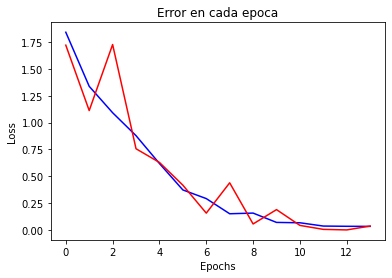

Training complete in 0m 47s


In [25]:
best_net_1 = train(net, optimizer, num_epocas=15)

# Sección 2.c Evaluar la red sobre los conjuntos de entrenamiento y validación, usando el mejor checkpoint almacenado

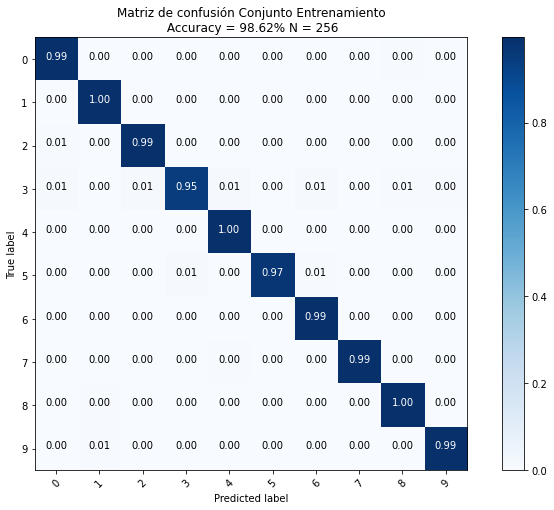

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


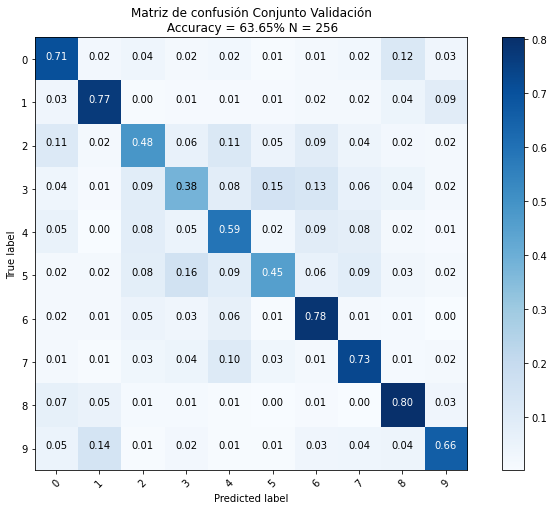

63.65

In [26]:
evaluar_red(best_net_1,N=256)

# Sección 3. Modificar el valor de N, repitiendo el Paso 2 hasta obtener una red con un buen desempeño.

Se prueban distintos valores de N, buscando obtener una red con mejor desempeño. Se selecciona el N que arroja mayor accuracy en el conjunto de validación.


Model con N=16
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 2.0076 Acc: 0.2385
Val Loss: 1.9860 Acc: 0.2575
Epoch 1/19
----------
Train Loss: 1.6347 Acc: 0.4080
Val Loss: 1.4600 Acc: 0.4416
Epoch 2/19
----------
Train Loss: 1.3104 Acc: 0.5410
Val Loss: 0.6602 Acc: 0.5404
Epoch 3/19
----------
Train Loss: 0.9886 Acc: 0.6572
Val Loss: 1.1142 Acc: 0.5589
Epoch 4/19
----------
Train Loss: 0.6886 Acc: 0.7604
Val Loss: 0.9419 Acc: 0.6219
Epoch 5/19
----------
Train Loss: 0.4332 Acc: 0.8538
Val Loss: 0.1906 Acc: 0.6376
Epoch 6/19
----------
Train Loss: 0.1990 Acc: 0.9365
Val Loss: 0.1712 Acc: 0.6526
Epoch 7/19
----------
Train Loss: 0.1239 Acc: 0.9593
Val Loss: 0.1403 Acc: 0.6432
Epoch 8/19
----------
Train Loss: 0.1112 Acc: 0.9671
Val Loss: 0.0748 Acc: 0.6469
Epoch 9/19
----------
Train Loss: 0.0500 Acc: 0.9858
Val Loss: 0.0046 Acc: 0.6595
Epoch 10/19
----------
Train Loss: 0.0232 Acc: 0.9936
Val Loss: 0.0192 Acc: 0.6669
Epoch 11/19
----------
Train Loss: 0.0129 Acc: 0.9977
Val Loss: 0.0028 Acc: 0.6729
Epoch 12/19
----------
Train Loss: 0

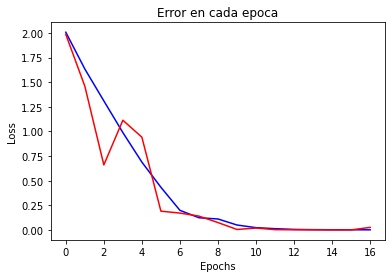

Training complete in 0m 54s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model con N=32
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.7382 Acc: 0.3633
Val Loss: 1.3448 Acc: 0.3622
Epoch 1/19
----------
Train Loss: 1.2143 Acc: 0.5598
Val Loss: 0.6763 Acc: 0.5702
Epoch 2/19
----------
Train Loss: 0.9339 Acc: 0.6652
Val Loss: 1.0933 Acc: 0.6133
Epoch 3/19
----------
Train Loss: 0.6754 Acc: 0.7595
Val Loss: 0.2923 Acc: 0.6303
Epoch 4/19
----------
Train Loss: 0.4026 Acc: 0.8617
Val Loss: 0.5350 Acc: 0.6601
Epoch 5/19
----------
Train Loss: 0.2291 Acc: 0.9236
Val Loss: 0.0852 Acc: 0.6704
Epoch 6/19
----------
Train Loss: 0.0995 Acc: 0.9691
Val Loss: 0.0676 Acc: 0.6662
Epoch 7/19
----------
Train Loss: 0.0514 Acc: 0.9838
Val Loss: 0.0089 Acc: 0.6727
Epoch 8/19
----------
Train Loss: 0.0270 Acc: 0.9917
Val Loss: 0.0030 Acc: 0.6660
Epoch 9/19
----------
Train Loss: 0.0173 Acc: 0.9946
Val Loss: 0.0016 Acc: 0.6759
Epoch 10/19
----------
Train Loss: 0.0094 Acc: 0.9982
Val Loss: 0.0036 Acc: 0.6833
Epoch 11/19
----------
Train Loss: 0.0060 Acc: 0.9985
Val Loss: 0.0016 Acc: 0.6766
Epoch 12/19
----------
Train Loss: 0

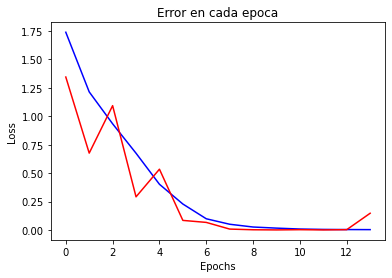

Training complete in 0m 45s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model con N=64
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.7133 Acc: 0.3767
Val Loss: 0.9315 Acc: 0.3258
Epoch 1/19
----------
Train Loss: 1.2426 Acc: 0.5549
Val Loss: 1.1525 Acc: 0.5381
Epoch 2/19
----------
Train Loss: 0.9628 Acc: 0.6550
Val Loss: 0.7372 Acc: 0.6090
Epoch 3/19
----------
Train Loss: 0.6924 Acc: 0.7493
Val Loss: 0.5458 Acc: 0.6163
Epoch 4/19
----------
Train Loss: 0.4261 Acc: 0.8480
Val Loss: 0.2443 Acc: 0.6456
Epoch 5/19
----------
Train Loss: 0.2346 Acc: 0.9214
Val Loss: 0.6723 Acc: 0.6277
Epoch 6/19
----------
Train Loss: 0.2354 Acc: 0.9225
Val Loss: 0.1449 Acc: 0.6513
Epoch 7/19
----------
Train Loss: 0.0919 Acc: 0.9700
Val Loss: 0.0254 Acc: 0.6590
Epoch 8/19
----------
Train Loss: 0.0368 Acc: 0.9878
Val Loss: 0.0992 Acc: 0.6601
Epoch 9/19
----------
Train Loss: 0.0759 Acc: 0.9757
Val Loss: 0.0172 Acc: 0.6510
Epoch 10/19
----------
Train Loss: 0.0328 Acc: 0.9896
Val Loss: 0.0030 Acc: 0.6608
Epoch 11/19
----------
Train Loss: 0.0144 Acc: 0.9953
Val Loss: 0.0002 Acc: 0.6627
Epoch 12/19
----------
Train Loss: 0

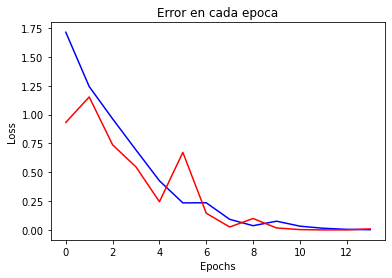

Training complete in 0m 45s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model con N=128
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.7569 Acc: 0.3637
Val Loss: 1.2897 Acc: 0.2867
Epoch 1/19
----------
Train Loss: 1.2921 Acc: 0.5315
Val Loss: 1.5105 Acc: 0.5361
Epoch 2/19
----------
Train Loss: 1.0240 Acc: 0.6236
Val Loss: 0.8734 Acc: 0.5909
Epoch 3/19
----------
Train Loss: 0.7645 Acc: 0.7230
Val Loss: 0.7189 Acc: 0.6164
Epoch 4/19
----------
Train Loss: 0.5065 Acc: 0.8223
Val Loss: 0.4686 Acc: 0.6211
Epoch 5/19
----------
Train Loss: 0.3025 Acc: 0.8949
Val Loss: 0.2368 Acc: 0.6289
Epoch 6/19
----------
Train Loss: 0.1797 Acc: 0.9368
Val Loss: 0.0604 Acc: 0.6319
Epoch 7/19
----------
Train Loss: 0.1215 Acc: 0.9568
Val Loss: 0.0724 Acc: 0.6349
Epoch 8/19
----------
Train Loss: 0.0887 Acc: 0.9702
Val Loss: 0.1279 Acc: 0.6413
Epoch 9/19
----------
Train Loss: 0.1056 Acc: 0.9661
Val Loss: 1.2371 Acc: 0.6397

----------Early Stopping----------

Best val loss: 0.0604


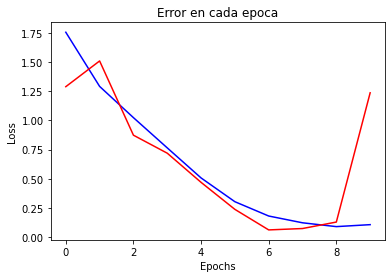

Training complete in 0m 34s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model con N=256
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.7742 Acc: 0.3715
Val Loss: 1.2981 Acc: 0.3751
Epoch 1/19
----------
Train Loss: 1.3099 Acc: 0.5220
Val Loss: 0.7761 Acc: 0.5347
Epoch 2/19
----------
Train Loss: 0.9958 Acc: 0.6401
Val Loss: 1.2233 Acc: 0.5589
Epoch 3/19
----------
Train Loss: 0.7541 Acc: 0.7274
Val Loss: 0.7185 Acc: 0.5840
Epoch 4/19
----------
Train Loss: 0.5132 Acc: 0.8156
Val Loss: 0.7009 Acc: 0.6027
Epoch 5/19
----------
Train Loss: 0.3017 Acc: 0.8940
Val Loss: 0.5661 Acc: 0.5868
Epoch 6/19
----------
Train Loss: 0.2601 Acc: 0.9108
Val Loss: 0.1650 Acc: 0.6061
Epoch 7/19
----------
Train Loss: 0.1168 Acc: 0.9601
Val Loss: 0.0164 Acc: 0.6265
Epoch 8/19
----------
Train Loss: 0.0629 Acc: 0.9793
Val Loss: 0.3659 Acc: 0.6225

----------Early Stopping----------

Best val loss: 0.0164


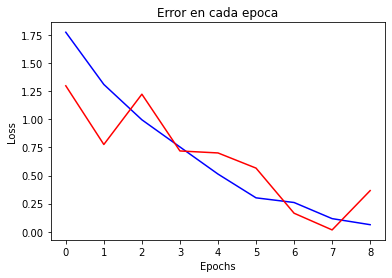

Training complete in 0m 31s


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
models = []
accuracys = []
n_list = [16,32,64,128,256]
for N in n_list:
    print(f'\nModel con N={N}')
    net = MyNet(N)
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 
    best_net = train(net, optimizer, num_epocas=20)
    models.append(best_net)
    accuracys.append(evaluar_red(best_net,N,plot=False))

## Resultados

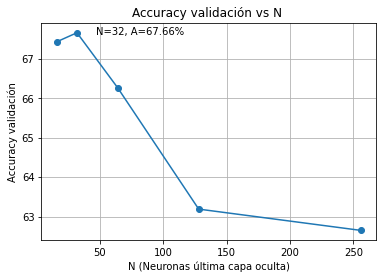

In [28]:
plt.plot(n_list,accuracys,'o-')
plt.title('Accuracy validación vs N ')
plt.ylabel('Accuracy validación')
plt.xlabel('N (Neuronas última capa oculta)')
plt.grid()
# Texto en la gráfica en coordenadas (x,y)
idx = np.argmax(accuracys)

texto1 = plt.text( n_list[idx]+15,accuracys[idx]-0.05, f'N={n_list[idx]}, A='+str(round(accuracys[idx],2))+'%', fontsize=10)

N = n_list[idx]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


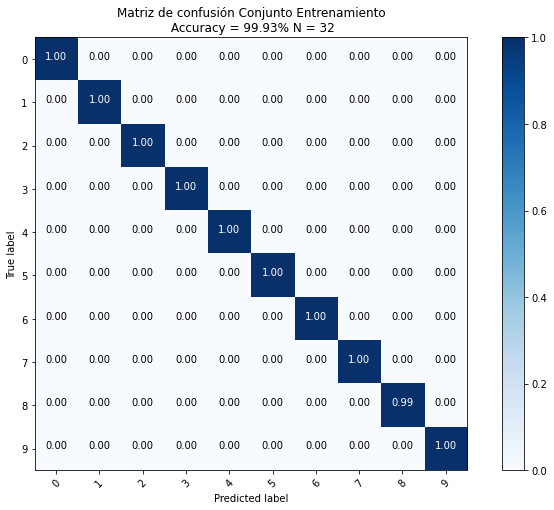

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


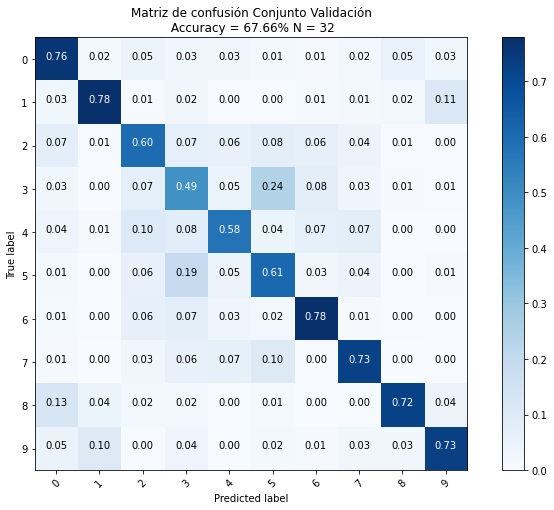

67.66

In [29]:
#evaluamos el desempeño con el modelo que entrega mejor accuracy de validación
evaluar_red(models[idx],n_list[idx])

# Sección 4. Repetir el Paso 2 usando dos números distintos de capas convolucionales y elija el que genere los mejores resultados

In [41]:
# agregando una capa convolucional más
class MyNet2(nn.Module):
 def __init__(self, N=128):
    super(MyNet2, self).__init__()
    self.nclasses = 10
    #nn.Conv2d(in_channels, out_channels, kernel_size)
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1) #64 filtros de 3x3, 3 canales de entrada
    self.conv2 = nn.Conv2d(64, 64, 3, padding = 1) 
    self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 256, 3, padding = 1)

    self.bn1 = torch.nn.BatchNorm2d(64)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.bn3 = torch.nn.BatchNorm2d(128)
    self.bn4 = torch.nn.BatchNorm2d(256)

    self.MaxPool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(4096, 1024)
    self.fc2 = nn.Linear(1024, 24*N)
    self.fc3 = nn.Linear(24*N, N)
    self.fc_last = nn.Linear(N, self.nclasses)
 def forward(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.MaxPool(self.bn2(F.relu(self.conv2(x))))
    x = self.MaxPool(self.bn3(F.relu(self.conv3(x))))
    x = self.MaxPool(self.bn4(F.relu(self.conv4(x))))

    #transformamos el tensor de una capa convolucional a una capa fully connected
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc_last(x)
    return x


Model con N=32
Epoch 0/19
----------
Train Loss: 1.7830 Acc: 0.3446
Val Loss: 1.7221 Acc: 0.3591
Epoch 1/19
----------
Train Loss: 1.3372 Acc: 0.5077
Val Loss: 1.1740 Acc: 0.5376
Epoch 2/19
----------
Train Loss: 1.0741 Acc: 0.6146
Val Loss: 1.2858 Acc: 0.5994
Epoch 3/19
----------
Train Loss: 0.8504 Acc: 0.6955
Val Loss: 0.6812 Acc: 0.6281
Epoch 4/19
----------
Train Loss: 0.6216 Acc: 0.7840
Val Loss: 0.6256 Acc: 0.6399
Epoch 5/19
----------
Train Loss: 0.4259 Acc: 0.8502
Val Loss: 0.4918 Acc: 0.6699
Epoch 6/19
----------
Train Loss: 0.2891 Acc: 0.9020
Val Loss: 0.1322 Acc: 0.6669
Epoch 7/19
----------
Train Loss: 0.1545 Acc: 0.9474
Val Loss: 0.1634 Acc: 0.6903
Epoch 8/19
----------
Train Loss: 0.1253 Acc: 0.9582
Val Loss: 0.1050 Acc: 0.6808
Epoch 9/19
----------
Train Loss: 0.0917 Acc: 0.9680
Val Loss: 0.3601 Acc: 0.6746
Epoch 10/19
----------
Train Loss: 0.1548 Acc: 0.9494
Val Loss: 0.0223 Acc: 0.6907
Epoch 11/19
----------
Train Loss: 0.0307 Acc: 0.9908
Val Loss: 0.0189 Acc: 0.697

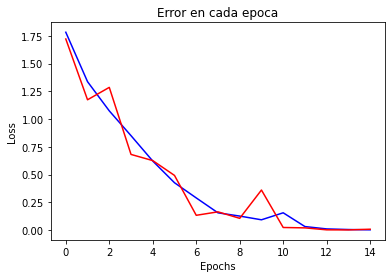

Training complete in 0m 54s


In [42]:

print(f'\nModel con N={N}')
net3 = MyNet2(N)
net3.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net3.parameters(), lr=1e-3) 
best_net3 = train(net3, optimizer, num_epocas=20)


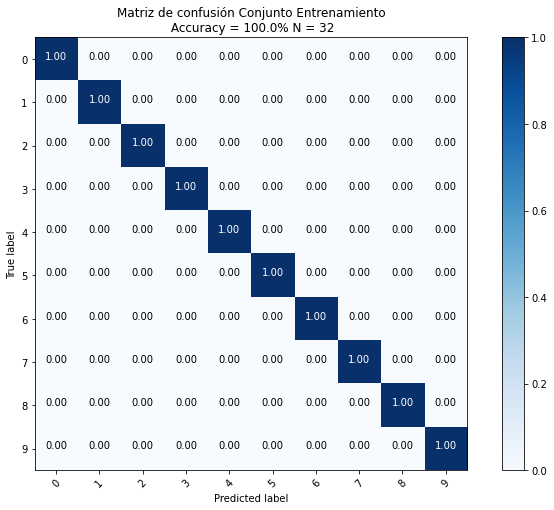

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


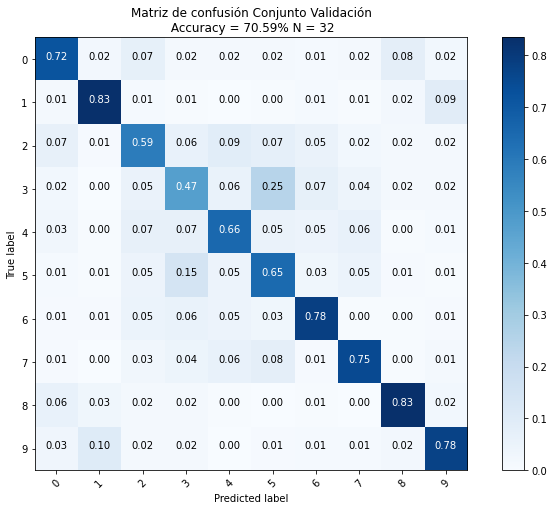

70.59

In [43]:
evaluar_red(best_net3,N)

In [44]:
#agregando 2 capas convolucionales más
class MyNet3(nn.Module):
 def __init__(self, N=16):
    super(MyNet3, self).__init__()
    self.nclasses = 10
    #nn.Conv2d(in_channels, out_channels, kernel_size)
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1) #64 filtros de 3x3, 3 canales de entrada
    self.conv2 = nn.Conv2d(64, 64, 3, padding = 1) 
    self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 256, 3, padding = 1)
    self.conv5 = nn.Conv2d(256, 512, 3, padding = 1)

    self.bn1 = torch.nn.BatchNorm2d(64)
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.bn3 = torch.nn.BatchNorm2d(128)
    self.bn4 = torch.nn.BatchNorm2d(256)
    self.bn5 = torch.nn.BatchNorm2d(512)

    self.MaxPool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(8192, 1024)
    self.fc2 = nn.Linear(1024, 24*N)
    self.fc3 = nn.Linear(24*N, N)
    self.fc_last = nn.Linear(N, self.nclasses)
 def forward(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.MaxPool(self.bn2(F.relu(self.conv2(x))))
    x = self.MaxPool(self.bn3(F.relu(self.conv3(x))))
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.MaxPool(self.bn5(F.relu(self.conv5(x))))

    #transformamos el tensor de una capa convolucional a una capa fully connected
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc_last(x)
    return x


Model con N=32
Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.9338 Acc: 0.2866
Val Loss: 1.4509 Acc: 0.2744
Epoch 1/19
----------
Train Loss: 1.5307 Acc: 0.4444
Val Loss: 1.4162 Acc: 0.4721
Epoch 2/19
----------
Train Loss: 1.2869 Acc: 0.5352
Val Loss: 1.5834 Acc: 0.5543
Epoch 3/19
----------
Train Loss: 1.1220 Acc: 0.6031
Val Loss: 1.1709 Acc: 0.5616
Epoch 4/19
----------
Train Loss: 0.9649 Acc: 0.6579
Val Loss: 1.7226 Acc: 0.6047
Epoch 5/19
----------
Train Loss: 0.8137 Acc: 0.7095
Val Loss: 0.5654 Acc: 0.6422
Epoch 6/19
----------
Train Loss: 0.6649 Acc: 0.7664
Val Loss: 0.6382 Acc: 0.6642
Epoch 7/19
----------
Train Loss: 0.5427 Acc: 0.8094
Val Loss: 0.8086 Acc: 0.6671
Epoch 8/19
----------
Train Loss: 0.4415 Acc: 0.8452
Val Loss: 0.6498 Acc: 0.6637
Epoch 9/19
----------
Train Loss: 0.4146 Acc: 0.8594
Val Loss: 0.2680 Acc: 0.7052
Epoch 10/19
----------
Train Loss: 0.2163 Acc: 0.9239
Val Loss: 0.2627 Acc: 0.6934
Epoch 11/19
----------
Train Loss: 0.1825 Acc: 0.9331
Val Loss: 0.0723 Acc: 0.7054
Epoch 12/19
----------
Train Loss: 0

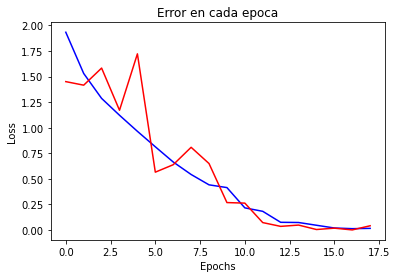

Training complete in 1m 35s


In [45]:

print(f'\nModel con N={N}')
net4 = MyNet3(N)
net4.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net4.parameters(), lr=1e-3) 
best_net4 = train(net4, optimizer, num_epocas=20)


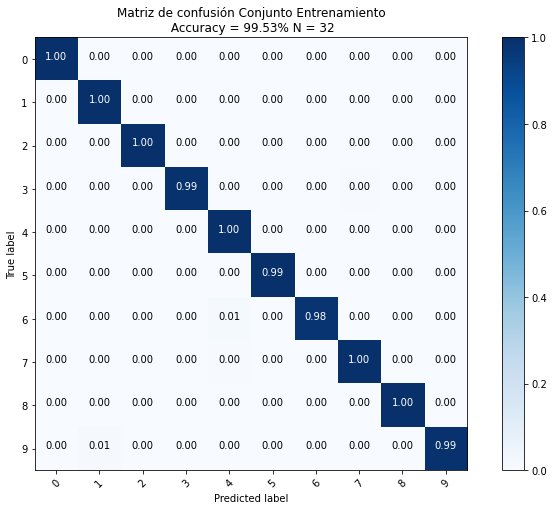

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


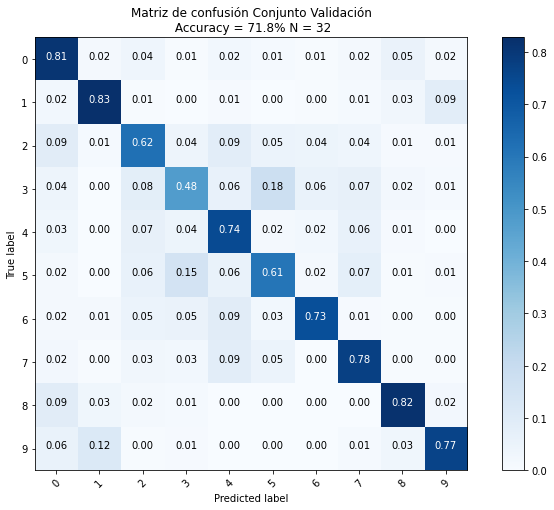

71.8

In [46]:
evaluar_red(best_net4,N)

# Sección 5. Usando la mejor configuración obtenida en los pasos anteriores, evaluar la mejor red sobre el conjunto de prueba.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


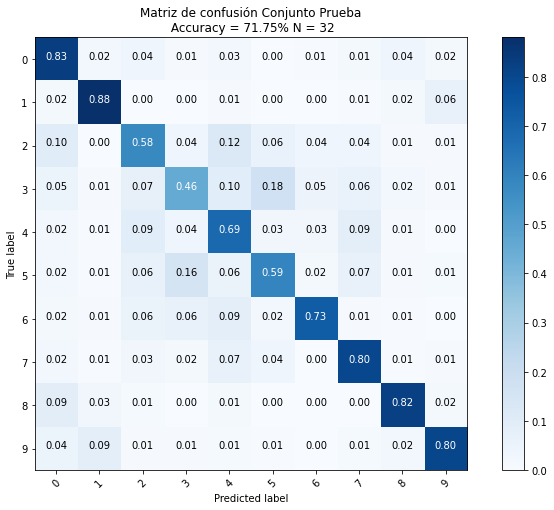

In [47]:
# calculate accuracy
from sklearn.metrics import  accuracy_score

#Evaluamos la red con los conjuntos de prueba
best_net4.eval()
y_pred = []
y_test = []
for labels,inputs in test_loader:
    inputs = inputs.to(device).float()
    labels = labels.to(device)
    y_test += labels.cpu().tolist()
    with torch.no_grad():
        outputs = best_net4(inputs)
        preds = outputs.argmax(axis=1)
        y_pred += preds.cpu().tolist()

accuracy = accuracy_score(y_test, y_pred)*100        
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(10)), accuracy,N, title="Matriz de confusión Conjunto Prueba")
